# Information 

The `Information` module of MIToS defines types and functions useful to calculate information measures (e.g. *Mutual Information* (MI) and *Entropy*) over a Multiple Sequence Alignment (MSA). This module was designed to count `Residue`s (defined in the `MSA` module) in special contingency tables (as fast as possible) and to derive probabilities from these counts.  Also, includes methods for applying corrections to those tables, e.g. pseudocounts and pseudo frequencies. Finally, `Information` allows to use these probabilities and counts to estimate information measures and other frequency based values.

## Features

- Estimate multi dimensional frequencies and probability tables from sequences, MSAs, etc...
- Correction for small number of observations
- Correction for data redundancy on a MSA
- Estimate information measures 
- Calculate corrected mutual information between residues  

In [1]:
# Truncate IJulia outputs at:
ENV["LINES"]   = 15 
ENV["COLUMNS"] = 60;

In [2]:
using MIToS.Information

## Counting residues

MIToS Information module defines two types of multidimensional `ResidueContingencyTables`: `ResidueCount` and `ResidueProbability` to store occurrences or probabilities. Those types store the contingency matrix, its marginal values and, in the case of counts, its total. Both are parametric types, taking three ordered parameters:
	
<p>
<dl class="dl-horizontal">
<dt><code>T</code></dt>
<dd>
The type used for storing the counts or probabilities, normally it is <code>Int</code> or <code>Float64</code> respectively. It is possible to use <code>BigInt</code> or <code>BigFloat</code> if more precision it is needed.
</dd>
<dt><code>N</code></dt>
<dd>
It is the dimension of the table and should be an <code>Int</code>.
</dd>
<dt><code>UseGap</code></dt>
<dd>
This should be a <code>Bool</code> value, where <code>true</code> means than the table is allocating space for counting gaps.
</dd>
</dl>
</p>

In this way, a matrix for storing pairwise probabilities of residues (without gaps) can be initialized with `ResidueProbability{Float64, 2, false}()` or the `zeros` function.

In [3]:
Pij = zeros(ResidueProbability{Float64, 2, false})

20x20 MIToS.Information.ResidueProbability{Float64,2,false}:
 0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮    ⋱  ⋮                      
 0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0

**[High level interface]** It is possible to use the functions `count` and `probabilities` to easily calculate the frequencies of sequences or columns of a MSA, where the number of sequences/columns determine the dimension of the resulting table.  

In [4]:
using MIToS.MSA # to use res"..." to create Vector{Residue}

column_i = res"AARANDDDRDC-"
column_j = res"-ARRNNADRAVY"
#   Nij[R,R] =   1  +  1   = 2

Nij = count(column_i, column_j)

20x20 MIToS.Information.ResidueCount{Float64,2,false}:
 1.0  1.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0
 0.0  2.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0
 2.0  0.0  1.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  1.0
 ⋮                        ⋮    ⋱  ⋮                      
 0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0

In [5]:
sum(Nij) # There are 12 Residues, but 2 are gaps

10.0

In [6]:
Nij[Int(Residue('R')), Int(Residue('R'))] # Use Int to index the table with residues

2.0

If you already have a `ResidueCount` table, you can fill a preallocated `ResidueProbability` table using the function `fill!`.

In [7]:
fill!(Pij, Nij)

20x20 MIToS.Information.ResidueProbability{Float64,2,false}:
 0.1  0.1  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0
 0.0  0.2  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.1  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0
 0.2  0.0  0.1  0.1  0.0  0.0     0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.1
 ⋮                        ⋮    ⋱  ⋮                      
 0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0

<a href="#"><i class="fa fa-arrow-up"></i></a>

#### Example: Plotting the probabilities of each residue in a sequence

We use the `getsequence` function, from the `MSA` module, to get the sequence from a `FASTA` downloaded from UniProt.  


In [8]:
using MIToS.MSA # to use getsequence on the one sequence FASTA

seq = getsequence(read("http://www.uniprot.org/uniprot/P29374.fasta", FASTA), 1)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1386  100  1386    0     0   2799      0 --:--:-- --:--:-- --:--:--  2800


1257-element MIToS.MSA.AnnotatedAlignedSequence:
 M
 K
 A
 A
 D
 ⋮
 A
 V
 E
 C
 R

**[High level interface]** To calculate the `probabilities`,  indicate the output type of the values followed by the sequences or columns. 

In [9]:
frequencies = probabilities(Float64, seq)

20-element MIToS.Information.ResidueProbability{Float64,1,false}:
 0.043755  
 0.0517104 
 0.0469372 
 0.0755768 
 0.0135243 
 ⋮         
 0.100239  
 0.0493238 
 0.00636436
 0.0198886 
 0.0517104 

In [10]:
# Pkg.add("Plots") # to install it
using Plots # We choose Plots because it's intuitive, concise and backend independent

# Pkg.add("PyPlot")
pyplot(size=(600,300))

Plots.PyPlotBackend()

You can plot together with the probabilities of each residue in a given sequence, the probabilities of each residue estimated with the BLOSUM62 substitution matrix. That matrix is exported as a constant by the `Information` module as `BLOSUM62_Pi`.  


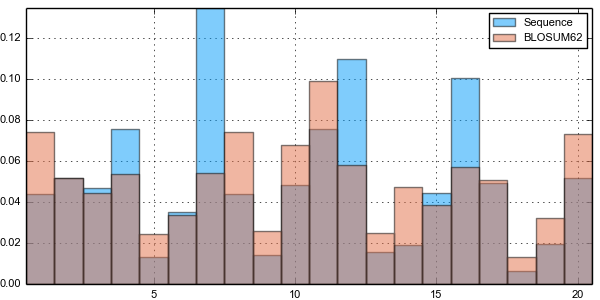

In [12]:
bar( 
    1:20, 
    [ frequencies  BLOSUM62_Pi ], 
    lab = [ "Sequence"  "BLOSUM62"   ], 
    alpha=0.5
)

<a href="#"><i class="fa fa-arrow-up"></i></a>  
  
## Low count corrections

Low number of observations can lead to sparse contingency tables, that lead to wrong probability estimations. It is shown in [*Buslje et. al. 2009*<span class="fa fa-external-link" aria-hidden="true"></span>](#http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2672635/) that low-count corrections, can lead to improvements in the contact prediction capabilities of the Mutual Information.  
The Information module has available two low-count corrections:  

1. [Additive Smoothing<span class="fa fa-external-link" aria-hidden="true"></span>](https://en.wikipedia.org/wiki/Additive_smoothing); the constant value pseudocount described in [*Buslje et. al. 2009*<span class="fa fa-external-link" aria-hidden="true"></span>](#http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2672635/).  
2. BLOSUM62 based pseudo frequencies of residues pairs, similar to [*Altschul et. al. 1997*<span class="fa fa-external-link" aria-hidden="true"></span>](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC146917/).  
    

In [13]:
using MIToS.MSA

msa = read("http://pfam.xfam.org/family/PF09776/alignment/full", Stockholm)

filtercolumns!(msa, columngapfraction(msa) .< 0.5) # delete columns with 50% gaps or more

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39823  100 39823    0     0  16045      0  0:00:02  0:00:02 --:--:-- 16044


143x102 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 -  -  -  -  -  -  -  -  -  …  D  -  -  -  -  -  -  -  -
 R  R  L  H  A  S  S  W  R     E  R  Y  R  Q  F  W  T  R
 -  -  -  -  -  -  V  R  T     K  K  Y  M  K  F  I  K  K
 -  -  -  -  -  -  -  -  -     K  K  Y  L  K  Y  L  K  K
 -  -  -  -  -  -  -  -  -     K  K  Y  M  K  Y  I  K  K
 ⋮              ⋮           ⋱        ⋮              ⋮   
 -  -  -  -  -  -  -  -  -     N  K  Y  S  Y  L  W  K  K
 -  -  F  S  T  S  T  V  F     E  S  Y  E  K  L  W  K  -
 H  H  L  H  T  S  S  I  Q  …  E  Q  Y  A  K  F  W  K  K
 R  H  L  H  T  S  P  W  R     E  R  Y  K  Q  F  W  T  K
 A  R  L  H  T  S  S  W  Q     E  Q  Y  K  R  F  W  T  K

In [14]:
column_i = msa[:,1]
column_j = msa[:,2]

143-element Array{MIToS.MSA.Residue,1}:
 -
 R
 -
 -
 -
 ⋮
 -
 -
 H
 H
 R

If you have a preallocated `ResidueCount` you can use `count!` to fill it, this prevent to create a new table as `count` do. However, you should note that `count!` <span class="text-warning">adds the new counts to the pre existing values</span>, so in this case, we want to start with a table initialized with zeros.  

In [15]:
Nij = zeros(ResidueCount{Int, 2, false})

count!(Nij, column_i, column_j)

20x20 MIToS.Information.ResidueCount{Int64,2,false}:
 0  1  0  0  0  0  0  1   0  …  0  0  0  0  0  0  0  0  0
 0  7  0  0  8  1  0  1  11     0  0  0  0  1  0  1  2  0
 0  0  0  0  1  0  0  0   0     0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0   0     0  0  0  0  0  0  0  0  0
 0  2  0  0  4  1  0  0   5     0  0  0  0  2  0  0  0  0
 ⋮              ⋮            ⋱              ⋮            
 0  0  0  0  2  0  0  1   0  …  0  0  2  0  4  0  0  0  0
 0  0  0  0  0  0  0  0   0     0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0   0     0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0   1     0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0   0     4  0  0  0  0  0  0  0  0

In cases like the above, where there are few observations, it is possible to apply a constant pseudocount to the counting table.  This module defines the type `AdditiveSmoothing` and the correspond `fill!` and  `apply_pseudocount!` methods to efficiently add or fill with a constant value each element of the table.

In [16]:
apply_pseudocount!(Nij, AdditiveSmoothing(1))

20x20 MIToS.Information.ResidueCount{Int64,2,false}:
 1  2  1  1  1  1  1  2   1  …  1  1  1  1  1  1  1  1  1
 1  8  1  1  9  2  1  2  12     1  1  1  1  2  1  2  3  1
 1  1  1  1  2  1  1  1   1     1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1   1     1  1  1  1  1  1  1  1  1
 1  3  1  1  5  2  1  1   6     1  1  1  1  3  1  1  1  1
 ⋮              ⋮            ⋱              ⋮            
 1  1  1  1  3  1  1  2   1  …  1  1  3  1  5  1  1  1  1
 1  1  1  1  1  1  1  1   1     1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1   1     1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1   2     1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1   1     5  1  1  1  1  1  1  1  1

**[High level interface]** The `count` function can take a `AdditiveSmoothing` value as first argument, to easily calculate occurrences with pseudocounts.

In [17]:
count(AdditiveSmoothing(1), column_i, column_j)

20x20 MIToS.Information.ResidueCount{Int64,2,false}:
 1  2  1  1  1  1  1  2   1  …  1  1  1  1  1  1  1  1  1
 1  8  1  1  9  2  1  2  12     1  1  1  1  2  1  2  3  1
 1  1  1  1  2  1  1  1   1     1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1   1     1  1  1  1  1  1  1  1  1
 1  3  1  1  5  2  1  1   6     1  1  1  1  3  1  1  1  1
 ⋮              ⋮            ⋱              ⋮            
 1  1  1  1  3  1  1  2   1  …  1  1  3  1  5  1  1  1  1
 1  1  1  1  1  1  1  1   1     1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1   1     1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1   2     1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1   1     5  1  1  1  1  1  1  1  1

To use the conditional probability matrix `BLOSUM62_Pij` in the calculation of pseudo frequencies $G$ for the pair of residues $a$, $b$, it should be calculated first the real frequencies/probabilities $p_{a,b}$. The observed probabilities are then used to estimate the pseudo frequencies.  
  
  
$$G_{ab} = \sum_{cd}  p_{cd} \cdot BLOSUM62( a | c ) \cdot BLOSUM62( b | d )$$

In [18]:
Pij = probabilities(Float64, column_i, column_j)

20x20 MIToS.Information.ResidueProbability{Float64,2,false}:
 0.0  0.0131579  0.0  0.0  …  0.0        0.0        0.0
 0.0  0.0921053  0.0  0.0     0.0131579  0.0263158  0.0
 0.0  0.0        0.0  0.0     0.0        0.0        0.0
 0.0  0.0        0.0  0.0     0.0        0.0        0.0
 0.0  0.0263158  0.0  0.0     0.0        0.0        0.0
 ⋮                         ⋱                           
 0.0  0.0        0.0  0.0  …  0.0        0.0        0.0
 0.0  0.0        0.0  0.0     0.0        0.0        0.0
 0.0  0.0        0.0  0.0     0.0        0.0        0.0
 0.0  0.0        0.0  0.0     0.0        0.0        0.0
 0.0  0.0        0.0  0.0     0.0        0.0        0.0

In [19]:
Gij = ResidueProbability{Float64, 2,false}() # doesn't need to be initialized with zeros

blosum_pseudofrequencies!(Gij, Pij)

20x20 MIToS.Information.ResidueProbability{Float64,2,false}:
 0.00409189   0.00550123   …  0.00216993   0.0027798  
 0.00882127   0.0159264       0.00788462   0.00655883 
 0.0023232    0.00268125      0.0014176    0.00173365 
 0.00186286   0.00227492      0.0011566    0.00137156 
 0.00587039   0.00793749      0.00301739   0.00371821 
 ⋮                         ⋱                          
 0.00437498   0.00425649   …  0.00233679   0.00321808 
 0.00260774   0.00314462      0.00150046   0.001866   
 0.000329611  0.000450226     0.000224725  0.000229916
 0.00123458   0.00160195      0.000946426  0.000844952
 0.00328513   0.00471087      0.00163396   0.00211435 

Finally, the probability $P$ of each pair of residues $a$, $b$ between the columns $i$, $j$ is the weighted mean between the observed frequency $p$ and BLOSUM62-based pseudo frequency $G$, where α is generally the number of clusters or the number of sequences of the MSA and β is an empiric weight value. β was determined to be close to `8.512`.  
  
$$P_{ab} = \frac{\alpha \cdot p_{ab} + \beta \cdot G_{ab} }{\alpha + \beta}$$

In [20]:
apply_pseudofrequencies!(Pij, Gij, nsequences(msa), 8.512)

20x20 MIToS.Information.ResidueProbability{Float64,2,false}:
 0.000229884  0.0127277    …  0.000121908  0.00015617 
 0.000495582  0.0878255       0.0252803    0.000368478
 0.000130518  0.000150633     7.96413e-5   9.73973e-5 
 0.000104656  0.000127806     6.49782e-5   7.70549e-5 
 0.000329801  0.0252833       0.000169518  0.00020889 
 ⋮                         ⋱                          
 0.000245788  0.000239131  …  0.000131282  0.000180793
 0.000146504  0.000176666     8.42962e-5   0.000104832
 1.85177e-5   2.52939e-5      1.26251e-5   1.29168e-5 
 6.9359e-5    8.99983e-5      5.31706e-5   4.74697e-5 
 0.00018456   0.000264659     9.17964e-5   0.000118785

**[High level interface]** The `probabilities` function has a signature to easily calculate the probabilities of each pair of residues using BLOSUM62 pseudo frequencies.  

In [21]:
probabilities(Float64, nsequences(msa), 8.512, column_i, column_j)

20x20 MIToS.Information.ResidueProbability{Float64,2,false}:
 0.000229884  0.0127277    …  0.000121908  0.00015617 
 0.000495582  0.0878255       0.0252803    0.000368478
 0.000130518  0.000150633     7.96413e-5   9.73973e-5 
 0.000104656  0.000127806     6.49782e-5   7.70549e-5 
 0.000329801  0.0252833       0.000169518  0.00020889 
 ⋮                         ⋱                          
 0.000245788  0.000239131  …  0.000131282  0.000180793
 0.000146504  0.000176666     8.42962e-5   0.000104832
 1.85177e-5   2.52939e-5      1.26251e-5   1.29168e-5 
 6.9359e-5    8.99983e-5      5.31706e-5   4.74697e-5 
 0.00018456   0.000264659     9.17964e-5   0.000118785

<a href="#"><i class="fa fa-arrow-up"></i></a>  

## Correction for data redundancy in a MSA  

A simple way to reduce redundancy in a MSA without losing sequences, is clusterization and sequence weigthing. 
The weight of each sequence should be 1/N, where N is the number of sequences in its cluster.  
The `SequenceCluster` type of the `MSA` module stores the weights. This vector of weights can be extracted (with the `getweight` function) and used by the `count` and `probabilities` functions with the keyword argument `weight`. Also it's possible to use the `SequenceCluster` as second argument of the function `count!`.  

In [22]:
clusters = hobohmI(msa, 62)

MIToS.MSA.SequenceClusters([1,41,14,2,1,1,1,1,6,1  …  1,3,1,1,1,2,1,1,1,1],[1,2,3,4,3,2,5,6,2,7  …  11,2,9,23,3,55,23,2,2,2],[1.0,0.0243902,0.0714286,0.5,0.0714286,0.0243902,1.0,1.0,0.0243902,1.0  …  0.333333,0.0243902,0.166667,0.25,0.0714286,1.0,0.25,0.0243902,0.0243902,0.0243902])

In [23]:
count(msa[:,1], msa[:,2], weight=clusters)

20x20 MIToS.Information.ResidueCount{Float64,2,false}:
 0.0  0.0243902  0.0  0.0  …  0.0        0.0      0.0
 0.0  1.62195    0.0  0.0     0.0243902  0.52439  0.0
 0.0  0.0        0.0  0.0     0.0        0.0      0.0
 0.0  0.0        0.0  0.0     0.0        0.0      0.0
 0.0  0.52439    0.0  0.0     0.0        0.0      0.0
 ⋮                         ⋱                         
 0.0  0.0        0.0  0.0  …  0.0        0.0      0.0
 0.0  0.0        0.0  0.0     0.0        0.0      0.0
 0.0  0.0        0.0  0.0     0.0        0.0      0.0
 0.0  0.0        0.0  0.0     0.0        0.0      0.0
 0.0  0.0        0.0  0.0     0.0        0.0      0.0

<a href="#"><i class="fa fa-arrow-up"></i></a>  

## Estimating information measures on an MSA

The `Information` module defines a hierarchy of types. Each concrete type of the hierarchy corresponds to a measure. At the time of writing this documentation, all the available measures are sub-types of `SymmetricMeasure{T}`, which in turn, is a sub-type of `AbstractMeasure{T}`. The type parameter `T` of the measure indicates the type of returned value.
The information measures based on logarithms have a `base` field to indicate the logarithm base (`e` by default).

- `Entropy{T}(base)` : Shannon entropy (H)
- `MutualInformation{T}(base)` : Mutual Information (MI)
- `MutualInformationOverEntropy{T}(base)` : Normalized Mutual Information (nMI) by Entropy
- `GapIntersectionPercentage{T}`
- `GapUnionPercentage{T}`

<p>
<div class="panel panel-info">
    <div class="panel-heading">
        <strong>Julia type system</strong>
    </div>
    <div class="panel-body">
        <p>In Julia, types are organized in an hierarchical mode (tree structure). The only types that can have instances (objects of that type) are called <strong>concrete types</strong> and they are in the leaf of the tree. <strong>Abstract types</strong> can have subtypes to organize the tree structure. Julia types can take <strong>parameters</strong> between brakets after the type name. If you want to know more about the Julia type system, read the <a href="http://docs.julialang.org/en/latest/manual/types/">Type chapter of the Julia manual<span class="fa fa-external-link" aria-hidden="true"></span>.</a></p>
    </div>
</div>
</p>

This module defines `estimate` functions for each above mentioned measure. Those functions take an instance of the measure type and a residue contingency table of counts or probabilities.  

In [24]:
Ni = count(res"PPCDPPPPPKDKKKKDDGPP") # Ni has the count table of residues in this low complexity sequence

H = estimate(Entropy{Float32}(), Ni) # returns the Shannon entropy in nats (base e)

dump(H) # the result it's Float32 as indicated (type parameter between brakets)

Float32 1.3273628


In [25]:
H = estimate(Entropy(2.0), Ni) # returns the Shannon entropy in nats (base 2)

dump(H) # the result it's Float64 because Entropy took the type of its base (2.0) as type parameter

Float64 1.9149798205164812


<p>
<div class="panel panel-success">
    <div class="panel-heading">
        <strong>Defining your own measures</strong>
    </div>
    <div class="panel-body">
        <p>If you want to define a new measure, you only need to define an  immutable sub-type of <code>AbstractMeasure{T}</code>. Your measure type should take the parameter <code>{T}</code> to indicate the output type, and you should define an <code>estimate</code> method.</p>
        <p>If you want to share your measure with this package, send a pull request. We will be glad to add it.</p>
    </div>
</div>
</p>

Two special iteration functions on `Information`: `estimateincolumns` and `estimateinsequences` were created specifically to easily and efficiently compute a measure over a MSA.   

<p>
<dl class="dl-horizontal">

<dt><code>aln</code></dt>
<dd>This argument is mandatory and it should be a <code>Matrix{Residue}</code>. Use the function <code>getresidues</code> (from the MSA module) over a MSA object to get the needed matrix.</dd>

<dt><code>count</code></dt>
<dd>This argument is optional. It should be defined when <code>use</code> is a <code>ResidueProbability</code> object. It indicates the element type of the counting table.</dd>

<dt><code>use</code></dt>
<dd>This argument is mandatory and indicates the sub-type of  <code>ResidueContingencyTables</code> used by <code>estimate</code> inside the function. If the table has one dimension (<code>N</code>=1), the occurrences/probabilities are counted for each sequence/column. If the table has two dimension (<code>N</code>=2), pairs of sequences/columns are used. <span class="text-info">The dimension <code>N</code> and the <code>UseGap</code> parameter of <code>ResidueCount{T, N, UseGap}</code> or <code>ResidueProbability{T, N, UseGap}</code> determines the output and behaviour of this functions.</span> If <code>UseGap</code> is true, gaps are used in the estimations.</dd> 

<dt><code>α</code></dt>
<dd>This argument is optional, and indicates the weight of real frequencies to apply BLOSUM62 based pseudo frequencies.</dd>

<dt><code>β</code></dt>
<dd>This argument is optional, and indicates the weight of BLOSUM62 based pseudo frequencies.</dd>

<dt><code>measure</code></dt>
<dd>This argument is mandatory and indicates the measure to be used by <code>estimate</code> inside the function. <span class="text-info">Its <code>T</code> parameter determines the element type of the output.</span></dd>

<dt><code>pseudocount</code></dt>
<dd>This argument is optional. It should be an <code>AdditiveSmoothing</code> instance (default to zero).</dd>

<dt><code>weight</code></dt>
<dd>This argument is optional. It should be an instance of <code>ClusteringResult</code> or <code>AbstractVector</code> (vector of weights). Each sequence has weight 1 (<code>NoClustering()</code> ) by default.</dd>

<dt><code>usediagonal</code></dt>
<dd>This functions return a <code>Vector</code> in the one dimensional case, or a <code>PairwiseListMatrix</code> in the bidimensional case. This argument only have sense in the bidimensional case and indicates if the list on the <code>PairwiseListMatrix</code> should include the diagonal (default to <code>true</code>).</dd>

<dt><code>diagonalvalue</code></dt>
<dd>This argument is optional (default to zero). Indicates the value of output diagonal elements.</dd>

</dl>
</p>

<a href="#"><i class="fa fa-arrow-up"></i></a>  

#### Example: Estimating *H(X)* and *H(X, Y)* over an MSA

In this example, we are going to use `estimateincolumns` to estimate **Shannon entropy** of MSA columns *H(X)* and the joint entropy *H(X, Y)* of columns pairs.  

In [26]:
using MIToS.MSA

msa = read("http://pfam.xfam.org/family/PF09776/alignment/full", Stockholm)

residues = getresidues(msa) # estimateincolumns functions take a Matrix{Residue}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39823  100 39823    0     0  39239      0  0:00:01  0:00:01 --:--:-- 39273


143x116 Array{MIToS.MSA.Residue,2}:
 -  -  -  -  -  -  -  -  -  …  D  -  -  -  -  -  -  -  -
 -  L  R  Q  S  T  V  K  A     E  R  Y  R  Q  F  W  T  R
 -  -  -  -  -  -  -  -  -     K  K  Y  M  K  F  I  K  K
 -  -  -  -  -  -  -  -  -     K  K  Y  L  K  Y  L  K  K
 -  -  -  -  -  -  -  -  -     K  K  Y  M  K  Y  I  K  K
 ⋮              ⋮           ⋱           ⋮              ⋮
 -  -  -  -  -  -  -  -  -     N  K  Y  S  Y  L  W  K  K
 -  -  -  -  -  -  -  -  -     E  S  Y  E  K  L  W  K  -
 -  L  Q  Q  N  L  A  K  I  …  E  Q  Y  A  K  F  W  K  K
 L  L  R  H  C  G  V  R  A     E  R  Y  K  Q  F  W  T  K
 -  L  Q  Q  P  V  L  T  R     E  Q  Y  K  R  F  W  T  K

We are going to count residues using `Int` values and to estimate the entropy using probabilities. The estimation is performed over `ResidueProbability{Float64,1,false}`, therefore the result will be a vector containing the values estimated over each column without counting gaps. The elements of the output vector will be `Float64` numbers, because this is the type parameter of the `Entropy` instance.  

In [27]:
Hx = estimateincolumns(msa, Int, ResidueProbability{Float64,1,false}, Entropy{Float64}())

116-element Array{Float64,1}:
 0.163024
 0.112516
 1.22214 
 0.743386
 1.88479 
 ⋮       
 1.78615 
 1.08626 
 1.0375  
 1.44439 
 0.433399

If we want the **joint entropy** between columns pairs, we only need to use a bidimensional table: `ResidueProbability{Float64,2,false}`.  

In [28]:
Hxy = estimateincolumns(msa, Int, ResidueProbability{Float64,2,false}, Entropy{Float64}())

116x116 PairwiseListMatrices.PairwiseListMatrix{Float64,true}:
 0.163024  0.163024  1.3024   …  1.27216  0.548874
 0.163024  0.112516  1.23808     1.22482  0.642912
 1.3024    1.23808   1.22214     2.12512  1.54128 
 0.692421  0.675859  1.80936     1.73041  1.30135 
 1.69842   1.74595   2.3126      2.605    2.15177 
 ⋮                            ⋱           ⋮       
 1.04919   1.0586    1.88399     2.48066  1.94791 
 0.334221  0.237819  1.31548     2.16892  1.42091 
 0.167944  0.119247  1.24073     2.11635  1.31343 
 1.27216   1.22482   2.12512     1.44439  1.65707 
 0.548874  0.642912  1.54128  …  1.65707  0.433399

In the above examples, we indicate the type of each occurrence in the counting and the probability table to use. Also, it's possible for some measures as **entropy** and **mutual information**, to estimate the values only with the count table (without calculate the probability table). Estimating measures only with a `ResidueCount` table, when this is possible, should be faster than using a probability table.  


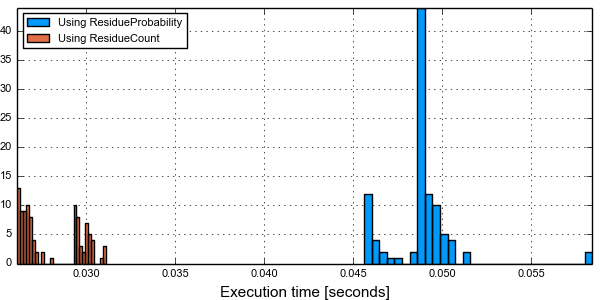

In [29]:
Time_Pab = map(0:100) do x
    
    time = @elapsed estimateincolumns(msa, Int, ResidueProbability{Float64,2,false}, Entropy{Float64}())
    
    x != 0 ? time : NaN
end

Time_Nab = map(0:100) do x
    
    time = @elapsed estimateincolumns(msa, ResidueCount{Int,2,false}, Entropy{Float64}())
    
    x != 0 ? time : NaN
end

histogram( [Time_Pab Time_Nab], 
labels = ["Using ResidueProbability" "Using ResidueCount"],
xlabel = "Execution time [seconds]" )

<a href="#"><i class="fa fa-arrow-up"></i></a>  

## Corrected Mutual Information  

MIToS ships with two methods to easily calculate corrected mutual information.  
The first is the algorithm described in  [*Buslje et. al. 2009*<span class="fa fa-external-link" aria-hidden="true"></span>](#http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2672635/). This algorithm can be accessed through the `buslje09` function and includes:  

1. Low count correction using `AdditiveSmoothing`
2. Sequence weighting after a `hobohmI` clustering
3. Average Product Correction (APC) proposed by [Dunn et. al. 2008<span class="fa fa-external-link" aria-hidden="true"></span>](#http://bioinformatics.oxfordjournals.org/content/24/3/333), through the `APC!` function that takes a MI matrix.  
4. Z score correction using the functions `shuffle_residues_sequencewise`from the MSA module and `zscore` from the `PairwiseListMatrices` package.

In [30]:
?buslje09

search: buslje09



This function takes a MSA or a file and a `Format` as first arguments. Calculates a Z score and a corrected MI/MIp as described on **Busjle et. al. 2009**

Argument, type, default value and descriptions:

```
  - lambda      Float64   0.05    Low count value
  - clustering  Bool      true    Sequence clustering (Hobohm I)
  - threshold             62      Percent identity threshold for clustering
  - maxgap      Float64   0.5     Maximum fraction of gaps in positions included in calculation
  - apc         Bool      true    Use APC correction (MIp)
  - usegap      Bool      false   Use gaps on statistics
  - samples     Int       100     Number of samples for Z-score
  - fixedgaps   Bool      true    Fix gaps positions for the random samples
```

This function returns:

```
  - Z score
  - MI or MIp
```


<div class="panel panel-info">
    <div class="panel-heading">
        <strong>Julia help mode</strong>
    </div>
    <div class="panel-body">
        <p>If you type <code>?</code> at the beginning of the Julia REPL line, you will enter in the Julia help mode. In this mode, Julia prints the help or <strong>documentation</strong> of the entered element. This is a nice way of getting information about MIToS functions, types, etc. from Julia.</p>
    </div>
</div>

The second, implemented in the `BLMI` function, has the same corrections that the above algorithm, but use BLOSUM62 pseudo frequencies. <span class="text-info">This function is slower than `buslje09` (at the same number of samples), but gives **better performance** (for structural contact prediction) when the MSA has **less than 400 clusters** after a Hobohm I at 62% identity.</span>

In [31]:
?MIToS.Information.BLMI

This function takes a MSA or a file and a `Format` as first arguments. Calculates a Z score (ZBLMI) and a corrected MI/MIp as described on **Busjle et. al. 2009** but using using BLOSUM62 pseudo frequencies instead of a fixed pseudocount.

Argument, type, default value and descriptions:

```
  - beta        Float64   8.512   β for BLOSUM62 pseudo frequencies
  - lambda      Float64   0.0     Low count value
  - threshold             62      Percent identity threshold for sequence clustering (Hobohm I)
  - maxgap      Float64   0.5     Maximum fraction of gaps in positions included in calculation
  - apc         Bool      true    Use APC correction (MIp)
  - samples     Int       50      Number of samples for Z-score
  - fixedgaps   Bool      true    Fix gaps positions for the random samples
```

This function returns:

```
  - Z score (ZBLMI)
  - MI or MIp using BLOSUM62 pseudo frequencies (BLMI/BLMIp)
```


<a href="#"><i class="fa fa-arrow-up"></i></a>  

#### Example: Estimating corrected MI from an MSA 

In [32]:
ZMIp, MIp  = buslje09("http://pfam.xfam.org/family/PF09776/alignment/full", Stockholm)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39823  100 39823    0     0  30151      0  0:00:01  0:00:01 --:--:-- 30146


(
102x102 PairwiseListMatrices.PairwiseListMatrix{Float64,false}:
 NaN          -0.485035  …    0.72701    -2.1086   
  -0.485035  NaN             -1.83368    -2.79612  
   2.48039     1.18754       -0.182761   -2.41242  
   1.73742     3.397         -1.07877    -3.11294  
   0.125531    2.05567       -0.732482   -2.50216  
   ⋮                     ⋱    ⋮                    
   1.50831     0.842787       0.372133   -1.53138  
  -0.59182    -0.23842       -1.44655    -0.0572045
  -1.40325    -0.922461      -3.56097    -2.27701  
   0.72701    -1.83368   …  NaN           1.83322  
  -2.1086     -2.79612        1.83322   NaN        ,

102x102 PairwiseListMatrices.PairwiseListMatrix{Float64,false}:
 NaN             0.0844148    0.134143   …   -0.118968  
   0.0844148   NaN            0.114736       -0.135227  
   0.134143      0.114736   NaN              -0.122186  
   0.118044      0.17467      0.235573       -0.129631  
   0.0768776     0.12383      0.196737       -0.119775  
   ⋮       

In [33]:
ZBLMIp, BLMIp  = BLMI("http://pfam.xfam.org/family/PF09776/alignment/full", Stockholm)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39823  100 39823    0     0  39136      0  0:00:01  0:00:01 --:--:-- 39157


(
102x102 PairwiseListMatrices.PairwiseListMatrix{Float64,false}:
 NaN           2.76915   …    1.13986     0.653381
   2.76915   NaN             -1.18973    -0.163105
   2.70018     3.08142        0.465089   -0.66852 
   3.02781     5.02235       -0.724444   -0.825268
   1.30653     3.33146        0.107101   -0.394246
   ⋮                     ⋱    ⋮                   
   0.72045     0.12194        1.90521     1.703   
  -1.36297    -1.21837        0.98981     1.29119 
  -2.4096     -1.87131       -0.622881    0.369148
   1.13986    -1.18973   …  NaN           2.30439 
   0.653381   -0.163105       2.30439   NaN       ,

102x102 PairwiseListMatrices.PairwiseListMatrix{Float64,false}:
 NaN            -0.128253   …    0.0934193   -0.0621987
  -0.128253    NaN              -0.0732681   -0.0830473
  -0.0328401    -0.0469063       0.0424627   -0.0903265
  -8.92122e-5    0.117112       -0.0326959   -0.0922052
  -0.101947     -0.0130386       0.0219162   -0.0404473
   ⋮                       

<a href="#"><i class="fa fa-arrow-up"></i></a>  

## Visualize Mutual Information

You can use the function of the Plot package to visualize the Mutual Information (MI) network between residues. As an example, we are going to visualize the MI between residues of the Pfam domain *PF00041*.  
The `heatmap` is the simplest way to visualize the values of the Mutual Information matrix. 

In [51]:
ZMIp, MIp  = buslje09("http://pfam.xfam.org/family/PF00041/alignment/full", Stockholm, samples=30)

# Pkg.add("GR") to install GR
gr()

heatmap(full(ZMIp), yflip=true)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 36.3M  100 36.3M    0     0   666k      0  0:00:55  0:00:55 --:--:--  886k


<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80

ZMIp is a Z score of the corrected MIp against its distribution on a random MSA (shuffling the residues in each sequence), so pairs with highest values are more likely to co-evolve. Here, we are going to use the top 1% pairs of MSA columns.  

In [52]:
threshold = quantile(ZMIp.list, 0.99)

65.63497339433836

In [53]:
ZMIp[ ZMIp .< threshold ] = NaN
ZMIp

82x82 PairwiseListMatrices.PairwiseListMatrix{Float64,false}:
 NaN  NaN  NaN       NaN       …  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN       NaN          NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN        84.9976     NaN  NaN  NaN  NaN  NaN
 NaN  NaN   84.9976  NaN          NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN        85.1647     NaN  NaN  NaN  NaN  NaN
   ⋮                           ⋱                   ⋮     
 NaN  NaN  NaN       NaN          NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN       NaN          NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN       NaN          NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN       NaN       …  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN       NaN          NaN  NaN  NaN  NaN  NaN

We are going to calculate the cMI (cumulative mutual information) value of each node. Where cMI is a mutual information score per position that characterizes the extent of mutual information "interactions" in its physical neighbourhood. This score is calculated as the sum of MI values above a certain threshold for every amino acid pair where the particular residue appears. This value defines to what degree a given amino acid takes part in a mutual information network and we are going to indicate it using the node color.

In [54]:
nrow, ncol = size(ZMIp)

cMI = map(1:ncol) do i
    col = ZMIp[:,i]
    sum(col[!isnan(col)])
end

82-element Array{Float64,1}:
   0.0   
   0.0   
  84.9976
 170.162 
  85.1647
   ⋮     
  73.7994
 211.653 
   0.0   
   0.0   
  90.1373

The nodes have an order, because they are columns in a MSA. So, the **arc diagram** it’s useful to visualize long and short association between MSA positions. Long interactions has more interest, in this case the longest interactions indicate covariation between two beta sheets. 

In [55]:
# Pkg.add("PlotRecipes") # to install it

using PlotRecipes

arcdiagram(Symmetric(ZMIp), size=(600,250), zcolor=cMI)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 10 
 
 
 20 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 
 
<polyline clip-path="url(#clip02)" style="stroke:#330c59; stroke-width:0.5; stroke-opacity:1; fill:none" points="
 68.6968,216.591 68.6781,216.185 68.6224,215.784 68.5302,215.392 68.4026,215.014 68.2412,214.655 68.0478,214.318 67.8247,214.009 67.5745,213.729 67.3001,213.483 
 67.0048,213.273 66.692,213.102 66.3654,212.973 66.0288,212.885 65.6862,212.841 65.3416,212.841 64.999,212.885 64.6624,212.973 64.3358,213.102 64.023,213.273 
 63.7277,213.483 63.4533,213.729 63.2031,214.009 62.98,214.318 62.7866,214.655 62.6252,215.014 62.4976,215.392 62.4054,215.784 62.3497,216.185 62.331,216.591 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#330c59; stroke-width:0.5; stroke-opacity:1; fill:none" points="
 75.0626,216.591 75.0439,216.185 74.9882,215.784 74.896,215.392 74.7684,215.014 74.607,214.655 74.4136,214.318 74.1904,214.009 73.9402,213.729 73.6659,213.483 
 73.3706,213.273 73.0578,213.102 72.7312,212.973 72.3946,212.885 72.052,212.841 71.7074,212.841 71.3647,212.885 71.0282,212.973 70.7016,213.102 70.3888,213.273 
 70.0935,213.483 69.8191,213.729 69.5689,214.009 69.3458,214.318 69.1524,214.655 68.991,215.014 68.8634,215.392 68.7712,215.784 68.7154,216.185 68.6968,216.591 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#00002d; stroke-width:0.5; stroke-opacity:1; fill:none" points="
 113.257,216.591 113.22,215.779 113.108,214.977 112.924,214.193 112.669,213.437 112.346,212.719 111.959,212.046 111.513,211.426 111.013,210.867 110.464,210.375 
 109.873,209.955 109.248,209.614 108.595,209.354 107.921,209.179 107.236,209.091 106.547,209.091 105.862,209.179 105.188,209.354 104.535,209.614 103.91,209.955 
 103.319,210.375 102.77,210.867 102.27,211.426 101.824,212.046 101.437,212.719 101.114,213.437 100.859,214.193 100.675,214.977 100.563,215.779 100.526,216.591 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#000034; stroke-width:0.5; stroke-opacity:1; fill:none" points="
 132.355,216.591 132.299,215.373 132.131,214.169 131.855,212.994 131.472,211.861 130.988,210.783 130.408,209.773 129.738,208.843 128.988,208.005 128.165,207.266 
 127.279,206.637 126.34,206.125 125.361,205.736 124.351,205.473 123.323,205.342 122.289,205.342 121.261,205.473 120.251,205.736 119.272,206.125 118.333,206.637 
 117.447,207.266 116.624,208.005 115.874,208.843 115.204,209.773 114.624,210.783 114.14,211.861 113.757,212.994 113.481,214.169 113.313,215.373 113.257,216.591 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#330c59; stroke-width:0.5; stroke-opacity:1; fill:none" points="
 406.083,216.591 405.318,199.944 403.032,183.492 399.252,167.428 394.022,151.941 387.403,137.211 379.474,123.412 370.326,110.706 360.068,99.2406 348.819,89.1514 
 336.711,80.5563 323.887,73.5561 310.497,68.2328 296.697,64.6489 282.65,62.8464 268.52,62.8464 254.472,64.6489 240.673,68.2328 227.282,73.5561 214.458,80.5563 
 202.351,89.1514 191.102,99.2406 180.843,110.706 171.696,123.412 163.766,137.211 157.147,151.941 151.917,167.428 148.137,183.492 145.851,199.944 145.086,216.591 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#00002d; stroke-width:0.5; stroke-opacity:1; fill:none" points="
 482.473,216.591 481.503,195.478 478.603,174.612 473.809,154.238 467.176,134.595 458.781,115.914 448.724,98.4129 437.122,82.2974 424.112,67.7564 409.845,54.9603 
 394.489,44.0592 378.224,35.1808 361.241,28.4294 343.739,23.8839 325.923,21.5978 308.002,21.5978 290.186,23.8839 272.684,28.4294 255.701,35.1808 239.436,44.0592 
 224.08,54.9603 209.813,67.7564 196.803,82.2974 185.201,98.4129 175.144,115.914 166.749,134.595 160.116,154.238 155.322,174.612 152.422,195.478 151.452,216.591 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#4c1177; stroke-width:0.5; stroke-opacity:1; fill:none" points="
 227.841,216.591 227.711,213.749 227.321,210.94 226.675,208.197 225.782,205.553 224.652,203.038 223.298,200.683 221.73

You can also use a **chord diagram** to see the same pattern.

In [56]:
chorddiagram(ZMIp, size=(600,600), color=:orange, alpha=0.5)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 - 
 
 
 1.0 
 
 
 - 
 
 
 0.5 
 
 
 0 
 
 
 0.5 
 
 
 1.0 
 
 
 
 - 
 
 
 1.0 
 
 
 - 
 
 
 0.5 
 
 
 0 
 
 
 0.5 
 
 
 1.0 
 
 
 
 
<polyline clip-path="url(#clip02)" style="stroke:#330c59; stroke-width:1.2; stroke-opacity:0.5; fill:none" points="
 532.225,252.115 517.674,254.89 504.155,257.424 491.665,259.717 480.205,261.769 469.775,263.58 460.376,265.15 452.007,266.479 444.668,267.567 438.359,268.415 
 433.08,269.022 428.831,269.387 425.612,269.512 423.424,269.396 422.265,269.039 422.137,268.441 423.039,267.602 424.971,266.522 427.933,265.202 431.926,263.64 
 436.948,261.838 443.001,259.795 450.084,257.51 458.196,254.985 467.339,252.219 477.513,249.212 488.716,245.964 500.949,242.476 514.213,238.746 528.507,234.776 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#330c59; stroke-width:1.2; stroke-opacity:0.5; fill:none" points="
 528.507,234.776 514.213,238.746 500.949,242.476 488.716,245.964 477.513,249.212 467.339,252.219 458.196,254.985 450.084,257.51 443.001,259.795 436.948,261.838 
 431.926,263.64 427.933,265.202 424.971,266.522 423.039,267.602 422.137,268.441 422.265,269.039 423.424,269.396 425.612,269.512 428.831,269.387 433.08,269.022 
 438.359,268.415 444.668,267.567 452.007,266.479 460.376,265.15 469.775,263.58 480.205,261.769 491.665,259.717 504.155,257.424 517.674,254.89 532.225,252.115 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#330c59; stroke-width:1.2; stroke-opacity:0.5; fill:none" points="
 528.507,234.776 514.202,238.705 500.908,242.312 488.623,245.597 477.347,248.559 467.081,251.199 457.824,253.516 449.577,255.51 442.339,257.182 436.111,258.531 
 430.892,259.558 426.682,260.262 423.482,260.644 421.292,260.703 420.11,260.44 419.939,259.854 420.777,258.945 422.624,257.714 425.481,256.161 429.347,254.285 
 434.222,252.086 440.107,249.565 447.002,246.721 454.906,243.555 463.819,240.066 473.742,236.255 484.675,232.121 496.616,227.665 509.568,222.886 523.528,217.784 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#330c59; stroke-width:1.2; stroke-opacity:0.5; fill:none" points="
 523.528,217.784 509.568,222.886 496.616,227.665 484.675,232.121 473.742,236.255 463.819,240.066 454.906,243.555 447.002,246.721 440.107,249.565 434.222,252.086 
 429.347,254.285 425.481,256.161 422.624,257.714 420.777,258.945 419.939,259.854 420.11,260.44 421.292,260.703 423.482,260.644 426.682,260.262 430.892,259.558 
 436.111,258.531 442.339,257.182 449.577,255.51 457.824,253.516 467.081,251.199 477.347,248.559 488.623,245.597 500.908,242.312 514.202,238.705 528.507,234.776 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#00002d; stroke-width:1.2; stroke-opacity:0.5; fill:none" points="
 491.706,155.251 479.832,164.464 468.75,172.954 458.462,180.719 448.967,187.761 440.265,194.078 432.356,199.672 425.24,204.542 418.917,208.687 413.387,212.109 
 408.65,214.807 404.706,216.781 401.555,218.031 399.197,218.557 397.633,218.359 396.861,217.437 396.882,215.791 397.697,213.421 399.304,210.327 401.704,206.509 
 404.898,201.968 408.884,196.702 413.664,190.712 419.236,183.999 425.602,176.561 432.761,168.4 440.712,159.514 449.457,149.905 458.995,139.571 469.326,128.514 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#00002d; stroke-width:1.2; stroke-opacity:0.5; fill:none" points="
 469.326,128.514 458.995,139.571 449.457,149.905 440.712,159.514 432.761,168.4 425.602,176.561 419.236,183.999 413.664,190.712 408.884,196.702 404.898,201.968 
 401.704,206.509 399.304,210.327 397.697,213.421 396.882,215.791 396.861,217.437 397.633,218.359 399.197,218.557 401.555,218.031 404.706,216.781 408.65,214.807 
 413.387,212.109 418.917,208.687 425.24,204.542 432.356,199.672 440.265,194.078 448.967,187.761 458.462,180.719 468.75,172.954 479.832,164.464 491.706,155.251 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#000034; stroke-width:1.2; stroke-opacity:0.5; fill:none" points="
 469.326,128.514 458.92,139.501 449.159,149.622